## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


=====================================================================================================


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


=====================================================================================================


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge


### How to make the PR

1) fork the repo:

Go to https://github.com/solegalli/udemy-feml-challenge, and click on the **fork** button at the top-right

2) clone your forked repo into your local computer:

- Go to www.github.com/yourusername/udemy-feml-challenge
- Click the green button that says clone or download
- copy the url that opens up
- power up a git console
- type: git clone (paste the url you copied from github)
- done

3) Make a copy of the jupyter notebook and add your name:

- Open up the Jupyter notebook called 13-Assignement.ipynb
- Click the "File" button at the top-right and then click "Make a copy"
- **Work your solution in the Copy** and not in the original assignment (otherwise there will be conflicts when making the PR)
- Change the name of the copy of the notebook to: 13-Assignement_yourname.ipynb
- done

When you finish, just commit the new notebook to your fork and then make a PR to my repo


## But i have a notebook ready and I haven't cloned the repo yet, how can I make the PR?

If you worked in the copy you downloaded from Udemy before forking and cloning this repo, then follow this steps:

1) fork the repo:

Go to https://github.com/solegalli/udemy-feml-challenge, and click on the fork button at the top-right

2) clone your forked repo into your local computer:

Go to www.github.com/yourusername/udemy-feml-challenge

- Click the green button that says clone or download
- Copy the url that opens up
- Power up a git console
- Type: git clone (paste the url you copied from github)
- Done

3) Rename your solution as follows and copy it into your cloned repo:

- Rename your solution notebook to: 13-Assignement_yourname.ipynb
- Copy this file into the cloned repo
- Done

When you finish, just commit the new notebook to your fork and then make a PR to my repo


**Good luck!!**

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

### Load Datasets

In [2]:
# load dataset

data = pd.read_csv('../Notebooks/houseprice.csv')

In [3]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [4]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [5]:
# calculate elapsed times

def elapsed_years(df, var1, var2):
    # capture difference between year variable and
    # year the house was sold
    
    df[var1 + '-' + var2] = abs(df[var1] - df[var2])
    return df

dates_vars = ['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for i, _ in enumerate(dates_vars):
    var1 = dates_vars[i]
    for j in range(i, len(dates_vars)):
        if i != j:
            var2 = dates_vars[j]
            X_train = elapsed_years(X_train, var1, var2)
            X_test = elapsed_years(X_test, var1, var2)

In [6]:
# drop original dates variables
X_train.drop(dates_vars, axis=1, inplace=True)
X_test.drop(dates_vars, axis=1, inplace=True)

In [7]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

In [8]:
# capture elapsed times variables
elapsed_times_vars = list(X_train.columns[-6:])
elapsed_times_vars

['YrSold-YearBuilt',
 'YrSold-YearRemodAdd',
 'YrSold-GarageYrBlt',
 'YearBuilt-YearRemodAdd',
 'YearBuilt-GarageYrBlt',
 'YearRemodAdd-GarageYrBlt']

## Feature Engineering Pipeline

In [9]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [10]:
# find percentage of missing values for categorical variables
categorical_vars_perc_nans = X_train[categorical].isna().mean()
categorical_vars_with_nans = categorical_vars_perc_nans[categorical_vars_perc_nans !=0]
categorical_vars_with_nans

Alley           0.938356
MasVnrType      0.004566
BsmtQual        0.024353
BsmtCond        0.024353
BsmtExposure    0.025114
BsmtFinType1    0.024353
BsmtFinType2    0.025114
Electrical      0.000761
FireplaceQu     0.472603
GarageType      0.056317
GarageFinish    0.056317
GarageQual      0.056317
GarageCond      0.056317
PoolQC          0.995434
Fence           0.814307
MiscFeature     0.961187
dtype: float64

In [11]:
# impute categorical variables with many missing values with the missing indicator otherwise with mode
tol = 0.05
categorical_impute_with_missing = (categorical_vars_with_nans[categorical_vars_with_nans > tol]).index
categorical_impute_with_mode = set(categorical).difference(set(categorical_impute_with_missing))
categorical_impute_with_missing = list(categorical_impute_with_missing)
categorical_impute_with_mode = list(categorical_impute_with_mode)

In [12]:
categorical_impute_with_missing

['Alley',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [13]:
categorical_impute_with_mode

['Condition1',
 'LotShape',
 'MasVnrType',
 'HeatingQC',
 'BsmtCond',
 'SaleType',
 'Condition2',
 'Exterior1st',
 'Exterior2nd',
 'HouseStyle',
 'RoofMatl',
 'Neighborhood',
 'ExterCond',
 'BsmtQual',
 'CentralAir',
 'RoofStyle',
 'LotConfig',
 'LandSlope',
 'BsmtExposure',
 'Functional',
 'Foundation',
 'KitchenQual',
 'SaleCondition',
 'MSZoning',
 'BldgType',
 'Utilities',
 'BsmtFinType2',
 'Street',
 'BsmtFinType1',
 'LandContour',
 'PavedDrive',
 'Heating',
 'ExterQual',
 'Electrical']

In [16]:
elapsed_times_vars_perc_nans = X_train[elapsed_times_vars].isna().mean()
elapsed_times_vars_with_nans = elapsed_times_vars_perc_nans[elapsed_times_vars_perc_nans !=0]
elapsed_times_vars_with_nans = list(elapsed_times_vars_with_nans.index)
elapsed_times_vars_with_nans 

['YrSold-GarageYrBlt', 'YearBuilt-GarageYrBlt', 'YearRemodAdd-GarageYrBlt']

In [17]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind',
     mdi.AddNaNBinaryImputer(
           variables=['LotFrontage', 'MasVnrArea'] + elapsed_times_vars_with_nans)),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
           variables=['LotFrontage', 'MasVnrArea'] + elapsed_times_vars_with_nans)),
    
    ('missing_cat', mdi.CategoricalVariableImputer(variables=categorical_impute_with_missing)),
    
    ('imputer_cat', mdi.FrequentCategoryImputer(variables=categorical_impute_with_mode)),

    
    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.05,
                                    n_categories=6,
                                    variables=categorical + discrete)),

    ('oh_categorical_enc',
     ce.OneHotCategoricalEncoder(top_categories=3,
                                 variables=categorical + discrete,
                                 drop_last=True)),

    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=5,
                                   return_object=True,
                                   variables=numerical)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=numerical)),
    
    
    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [18]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\rocco\anaconda3\envs\udemy-feature-engineering-course\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401417341105.6948, tolerance: 820439508.582228
  positive)


In [25]:
# check model performance:

print('train mse: {}'.format(round(mean_squared_error(y_train, X_train_preds),2)))
print('train rmse: {}'.format(round(sqrt(mean_squared_error(y_train, X_train_preds)),2)))
print('train r2: {}'.format(round(r2_score(y_train, X_train_preds),2)))
print()
print('test mse: {}'.format(round(mean_squared_error(y_test, X_test_preds),2)))
print('test rmse: {}'.format(round(sqrt(mean_squared_error(y_test, X_test_preds)),2)))
print('test r2: {}'.format(round(r2_score(y_test, X_test_preds),2)))

train mse: 741773912.9
train rmse: 27235.53
train r2: 0.88

test mse: 1584382260.55
test rmse: 39804.3
test r2: 0.77


Text(0, 0.5, 'Predicted Price')

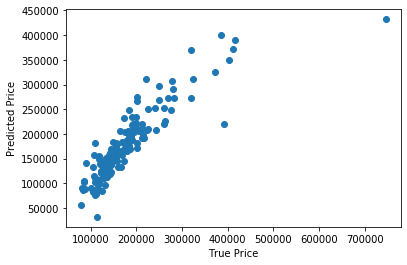

In [20]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')